In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
# 残差块的实现如下:

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
# 查看输入和输出形状一致的情况
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
# 可以在增加输出通道数的同时，减半输出的高和宽
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
# ResNet的前两层跟之前介绍的 GoogLeNet中的一样： 在输出通道数为 64、步幅为 2的 7×7卷积层后，接步幅为 2的
# 3×3最大汇聚层。 不同之处在于 ResNet每个卷积层后增加了批量规范化层。

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
# 实现模块并对第一个模块的特殊处理

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
# 接着在ResNet加入所有残差块，这里每个模块使用2个残差块

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
# 最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [9]:
# 在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，
# 通道数量增加，直到全局平均汇聚层聚集所有特征。

X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.014, train acc 0.997, test acc 0.914
2909.3 examples/sec on cuda:0


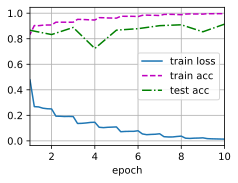

In [10]:
# 同之前一样，我们在Fashion-MNIST数据集上训练ResNet
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 确保你指定的路径是你有写权限的路径
data_dir = './data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

transform = transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
mnist_train = datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=True)
mnist_test = datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=True)

# 创建 DataLoader
batch_size = 256  # 根据你需要的批次大小设置
train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# 然后继续训练
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.154, train acc 0.943, test acc 0.853
726.4 examples/sec on cuda:0


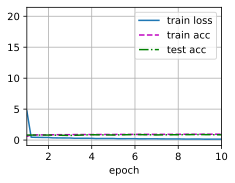

In [23]:
# 参考ResNet论文 (He et al., 2016)中的表 1，以实现不同的变体

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 定义残差块类
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()  # 调用父类初始化方法
        # 第一个卷积层，用于减少输入特征图的尺寸和通道数（如果需要的话）
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        # 第二个卷积层，保持特征图尺寸不变
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        # 如果需要使用 1x1 卷积层来匹配输入和输出的通道数，则创建该层
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        # 批归一化层，分别用于两个卷积层后的输出
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        # 输入经过第一个卷积层、批归一化层和 ReLU 激活函数
        Y = F.relu(self.bn1(self.conv1(X)))
        # 上一步结果再经过第二个卷积层和批归一化层
        Y = self.bn2(self.conv2(Y))
        
        # 如果使用了 1x1 卷积层，则对输入 X 进行相同操作
        if self.conv3:
            X = self.conv3(X)
        # 将两部分结果相加，并通过 ReLU 激活函数
        Y += X
        return F.relu(Y)


# 定义ResNet的基本块函数
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []  # 初始化空列表用于存储残差块
    for i in range(num_residuals):
        # 对于每个残差块，根据是否为第一块以及是否需要下采样来决定参数
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk  # 返回包含多个残差块的列表


# 定义ResNet网络架构
class ResNet(nn.Module):
    def __init__(self, num_classes, block_sizes):
        super().__init__()
        # 网络的第一层，包括一个 7x7 的卷积层，一个批量归一化层，一个 ReLU 激活函数和一个最大池化层
        self.b1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # 定义四个残差块，每个残差块由多个残差单元组成
        self.b2 = nn.Sequential(*resnet_block(64, 64, block_sizes[0], first_block=True))  # 第一个残差块
        self.b3 = nn.Sequential(*resnet_block(64, 128, block_sizes[1]))  # 第二个残差块
        self.b4 = nn.Sequential(*resnet_block(128, 256, block_sizes[2]))  # 第三个残差块
        self.b5 = nn.Sequential(*resnet_block(256, 512, block_sizes[3]))  # 第四个残差块

        # 最后一层包括自适应平均池化层、展平层和全连接层
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, X):
        # 前向传播过程，依次通过各个层
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.avgpool(X)
        X = self.flatten(X)
        X = self.fc(X)
        return X


# 定义不同层数的ResNet模型
def resnet18(num_classes):
    return ResNet(num_classes, [2, 2, 2, 2])  # ResNet18

def resnet34(num_classes):
    return ResNet(num_classes, [3, 4, 6, 3])  # ResNet34

def resnet50(num_classes):
    return ResNet(num_classes, [3, 4, 6, 3])  # ResNet50

def resnet101(num_classes):
    return ResNet(num_classes, [3, 4, 23, 3])  # ResNet101

def resnet152(num_classes):
    return ResNet(num_classes, [3, 8, 36, 3])  # ResNet152


# 示例用法
num_classes = 10  # 输出类别数
net = resnet152(num_classes)  # 创建一个 ResNet50实例

# 数据集路径设置
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# 数据预处理
transform = transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
mnist_train = datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=True)
mnist_test = datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=True)

# 数据加载器
batch_size = 256  # 设置批次大小
train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# 训练网络
lr, num_epochs = 0.1, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
